In [2]:
import pandas as pd
import numpy as np

# Data Preprocessing

In [3]:
industry_df = pd.read_csv("./data/업종거래소.csv", header = [0,1], index_col = 0)
industry_df = industry_df.xs('거래소 업종 (세부분류)', level=1, axis=1)
industry_df.dropna(how = 'all', inplace= True)
industry_df
financial_industries = [
    '금융',
    '코스피 금융업',
    '코스피 보험',
    '코스피 증권',
    '코스피 은행',
]

filter_df = industry_df.iloc[-1]
columns_to_remove = list(filter_df[filter_df.isin(financial_industries)].index)
#industry_df = industry_df.drop(columns=columns_to_remove)
price_df = pd.read_csv("./data/수정주가.csv", thousands= ',', index_col = 0)
price_df = price_df.drop(columns=columns_to_remove)
price_df.index = pd.to_datetime(price_df.index)
price_df.index.name = 'Date'
price_df

,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,셀트리온,기아,POSCO홀딩스,NAVER,삼성SDI,...,에스앤씨엔진그룹,차이나하오란,웨이포트,성융광전투자,완리,평산차업 KDR,네프로아이티,중국고섬,SBI모기지,SNK
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,429,NaN,NaN,NaN,17203,NaN,199967,28303,NaN,21602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,434,NaN,NaN,NaN,17439,NaN,203091,28756,NaN,21697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,425,NaN,NaN,NaN,17085,NaN,199967,28484,NaN,20985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-06,426,NaN,NaN,NaN,17027,NaN,198405,28847,NaN,21127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,422,NaN,NaN,NaN,17262,NaN,201529,28938,NaN,21127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,76100,179600.0,378000.0,962000.0,249500,205000.0,102800,345000,170700.0,332000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-27,75800,175000.0,376500.0,973000.0,247500,200500.0,101800,346000,167900.0,338000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-28,76400,179300.0,368500.0,991000.0,259000,201500.0,104600,336500,163800.0,339500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
returns_df = price_df.pct_change(1)
returns_df

,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,셀트리온,기아,POSCO홀딩스,NAVER,삼성SDI,...,에스앤씨엔진그룹,차이나하오란,웨이포트,성융광전투자,완리,평산차업 KDR,네프로아이티,중국고섬,SBI모기지,SNK
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.011655,NaN,NaN,NaN,0.013719,NaN,0.015623,0.016005,NaN,0.004398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,-0.020737,NaN,NaN,NaN,-0.020299,NaN,-0.015382,-0.009459,NaN,-0.032816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-06,0.002353,NaN,NaN,NaN,-0.003395,NaN,-0.007811,0.012744,NaN,0.006767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,-0.009390,NaN,NaN,NaN,0.013802,NaN,0.015746,0.003155,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,-0.020592,-0.031806,0.052925,0.005225,-0.011881,0.012346,-0.011538,0.014706,0.035173,0.004539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-27,-0.003942,-0.025612,-0.003968,0.011435,-0.008016,-0.021951,-0.009728,0.002899,-0.016403,0.018072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-28,0.007916,0.024571,-0.021248,0.018499,0.046465,0.004988,0.027505,-0.027457,-0.024419,0.004438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
columns_to_remove

['KB금융',
 '신한지주',
 '삼성생명',
 '메리츠금융지주',
 '하나금융지주',
 '삼성화재',
 'LG',
 'HD한국조선해양',
 '우리금융지주',
 '기업은행',
 'SK',
 'SK스퀘어',
 '에코프로',
 '카카오뱅크',
 'DB손해보험',
 'HD현대',
 '미래에셋증권',
 '삼성카드',
 '한진칼',
 'NH투자증권',
 '삼성증권',
 'GS',
 '한국금융지주',
 'CJ',
 '키움증권',
 'LS',
 '카카오페이',
 'BNK금융지주',
 'JB금융지주',
 '현대해상',
 '두산',
 '롯데지주',
 '한화생명',
 '한미사이언스',
 '한국앤컴퍼니',
 '코리안리',
 'DGB금융지주',
 'OCI홀딩스',
 '신영증권',
 '영원무역홀딩스',
 '동원산업',
 '오리온홀딩스',
 '미래에셋생명',
 '동양생명',
 '쿠쿠홀딩스',
 '대신증권',
 '효성',
 '롯데손해보험',
 '현대지에프홀딩스',
 'LS에코에너지',
 '동아쏘시오홀딩스',
 '한화투자증권',
 '세아제강지주',
 'HDC',
 '한화손해보험',
 'SK디스커버리',
 '삼양홀딩스',
 '교보증권',
 '유안타증권',
 '하림지주',
 '우리기술투자',
 'LX홀딩스',
 'F&F홀딩스',
 '유진투자증권',
 '풍산홀딩스',
 '한국자산신탁',
 'SNT홀딩스',
 'HL홀딩스',
 'BGF',
 '스틱인베스트먼트',
 '농심홀딩스',
 '대상홀딩스',
 '부국증권',
 '현대차증권',
 '제주은행',
 '콜마홀딩스',
 '한국토지신탁',
 '미래에셋벤처투자',
 'DB금융투자',
 'SK증권',
 '동국홀딩스',
 '아주IB투자',
 '흥국화재',
 'JW홀딩스',
 '하이트진로홀딩스',
 '해성산업',
 '대덕',
 '한양증권',
 '미원홀딩스',
 '코오롱',
 '일진홀딩스',
 '다올투자증권',
 '경동인베스트',
 '유비쿼스홀딩스',
 '한국캐피탈',
 '비츠로테크',
 'AK홀딩스',
 '티와이홀딩스',
 '노루홀딩스',
 '서연',
 '

In [6]:
factor_df = pd.read_csv("./data/팩터모델.csv", index_col=0)
factor_df.index = pd.to_datetime(factor_df.index)
factor_df.index.name = 'Date'
factor_df = factor_df.rename(columns= dict(zip(factor_df.columns, ["HML", "SMB", "MOM", "MKT"])))
factor_df = factor_df / 100 # % -> 0.01
factor_df

,HML,SMB,MOM,MKT
Date,,,,
1990-01-03,NaN,NaN,NaN,-0.0012
1990-01-04,NaN,NaN,NaN,0.0223
1990-01-05,NaN,NaN,NaN,-0.0148
1990-01-06,NaN,NaN,NaN,-0.0025
1990-01-08,NaN,NaN,NaN,0.0072
...,...,...,...,...
2024-08-26,0.0002,-0.0091,-0.0092,-0.0014
2024-08-27,-0.0019,0.0046,-0.0035,-0.0032
2024-08-28,-0.0041,-0.0050,0.0098,0.0002


In [23]:
!pip install networkx

Primitives by type after setup_gp:
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than', 'Filter', 'Avg', 'Max', 'Min', 'Median', 'Lag', 'Volatility', 'RSI']
Type <class 'int'>: ['get_int_constant']
Type <class 'float'>: []
Primitives by type:
Type <class 'pandas.core.series.Series'>: ['if_then_else', 'and_op', 'or_op', 'greater_than', 'less_than', 'Filter', 'Avg', 'Max', 'Min', 'Median', 'Lag', 'Volatility', 'RSI']
Type <class 'int'>: ['get_int_constant']
Type <class 'float'>: []
Terminals by type:
Type <class 'pandas.core.series.Series'>: ['ARG0']
Type <class 'int'>: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '

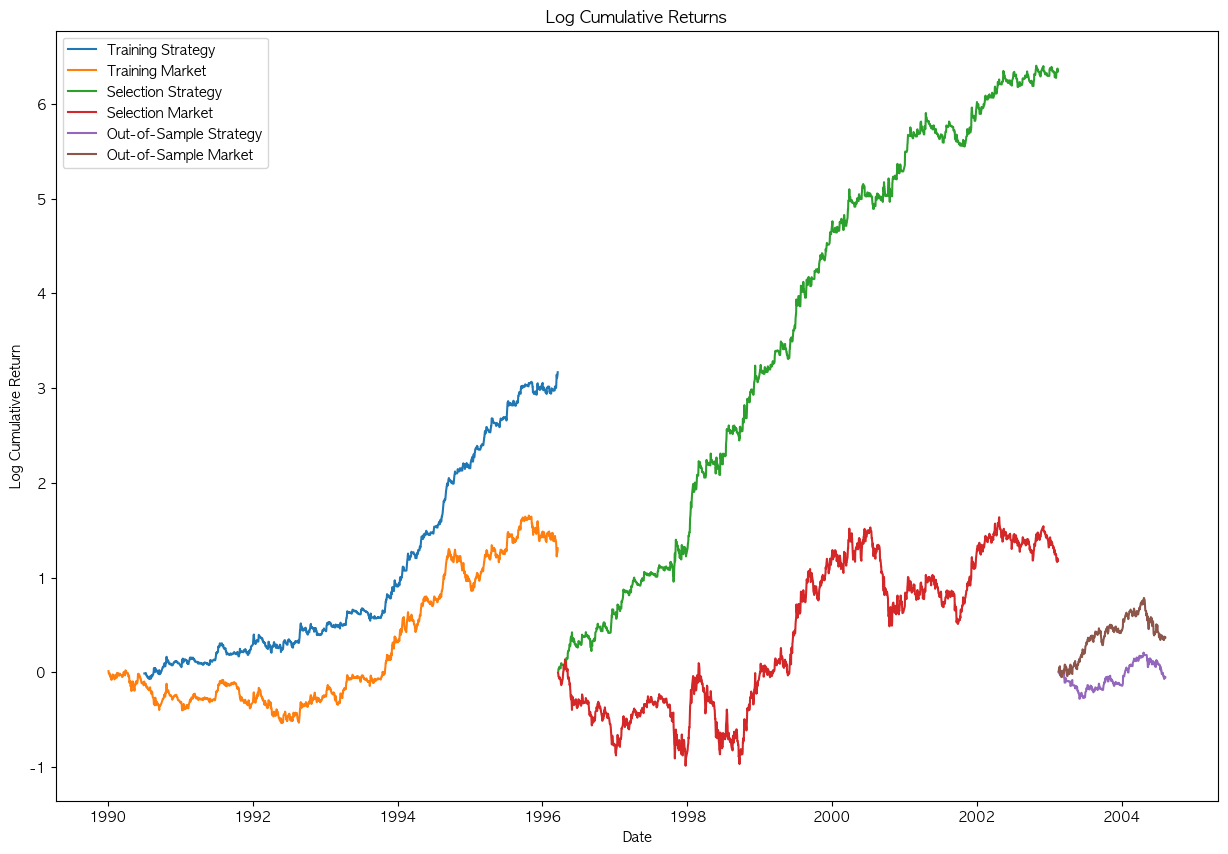

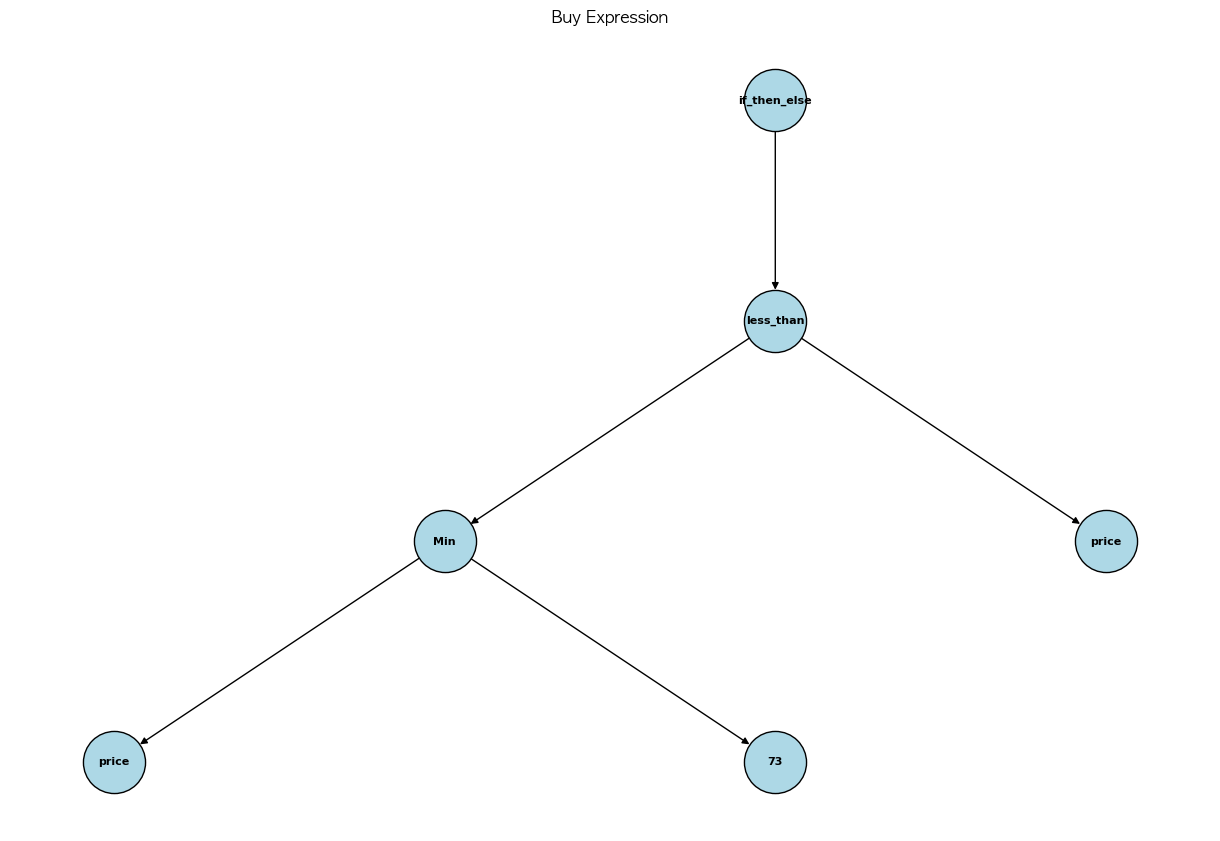

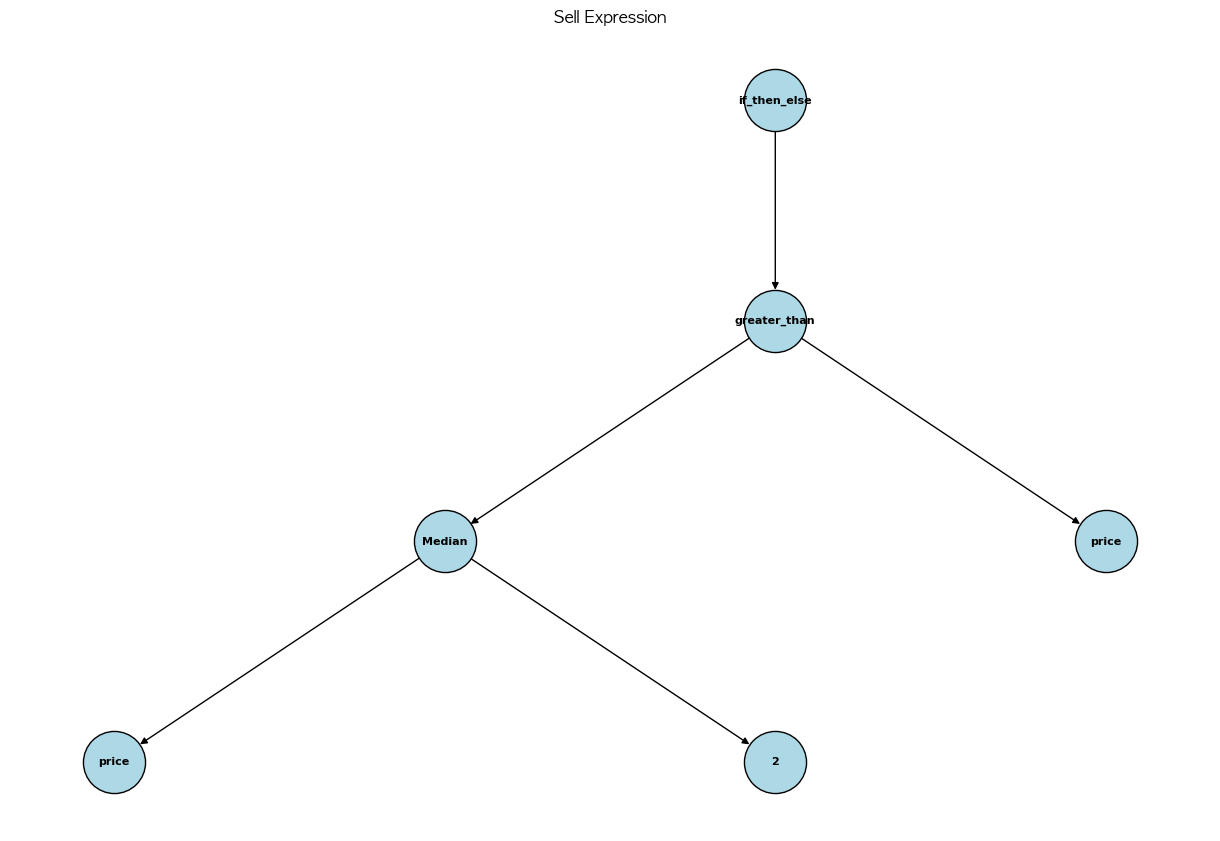

In [93]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, gp
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import warnings
import copy  # 추가: deepcopy 사용을 위해 import
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요 시 주석 해제)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

class GeneticProgrammingTrader:
    def __init__(self, price_df, factor_df, training_years=5, selection_years=5, out_sample_years=1, days_per_year=365):
        """
        초기화 메서드
        :param price_df: 주가 데이터 DataFrame
        :param factor_df: 팩터 데이터 DataFrame
        :param training_years: 학습 기간 (년)
        :param selection_years: 선택 기간 (년)
        :param out_sample_years: 외부 검증 기간 (년)
        :param days_per_year: 연도당 일수
        """
        self.price_df = price_df
        self.factor_df = factor_df
        self.training_years = training_years
        self.selection_years = selection_years
        self.out_sample_years = out_sample_years
        self.days_per_year = days_per_year
        self.setup_data()
        self.setup_gp()
    
    def setup_data(self):
        """
        데이터를 학습, 선택, 외부 검증 기간으로 분할
        """
        total_days = len(self.price_df)
        training_days = self.training_years * self.days_per_year
        selection_days = self.selection_years * self.days_per_year
        out_sample_days = self.out_sample_years * self.days_per_year
        
        if total_days < training_days + selection_days + out_sample_days:
            raise ValueError(f"데이터가 충분히 길지 않습니다. 최소 {self.training_years + self.selection_years + self.out_sample_years}년의 데이터가 필요합니다.")
        
        self.training_df = self.price_df.iloc[:training_days]
        self.selection_df = self.price_df.iloc[training_days:training_days + selection_days]
        self.out_sample_df = self.price_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]
        
        self.training_factors = self.factor_df.iloc[:training_days]
        self.selection_factors = self.factor_df.iloc[training_days:training_days + selection_days]
        self.out_sample_factors = self.factor_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]
        #self.out_sample_factors = self.factor_df.iloc[training_days + selection_days:training_days + selection_days + out_sample_days]  # 수정
        
        # 학습 및 선택 기간을 결합하여 GP 진화에 사용
        #self.combined_price = pd.concat([self.training_df, self.selection_df])
        #self.combined_factors = pd.concat([self.training_factors, self.selection_factors])
        
        # 외부 검증 데이터
        self.out_sample_price = self.out_sample_df['삼성전자']
        self.out_sample_factors = self.out_sample_factors
    
    def setup_gp(self):
        """
        GP 프리미티브 및 DEAP 툴박스 설정
        """
        # 3-2. 연산자 및 터미널 집합 정의 (타이핑된 GP 사용)
        # 입력 타입: pd.Series, int; 출력 타입: pd.Series
        self.pset = gp.PrimitiveSetTyped("MAIN", [pd.Series], pd.Series)
        self.pset.renameArguments(ARG0='price')
        
        # Level 1: Boolean operators and functions
        def if_then_else(condition):
            return pd.Series(np.where(condition > 0, 1, 0), index=condition.index)

        def and_op(a, b):
            return pd.Series(np.logical_and(a > 0, b > 0).astype(float), index=a.index)
        
        def or_op(a, b):
            return pd.Series(np.logical_or(a > 0, b > 0).astype(float), index=a.index)

        self.pset.addPrimitive(if_then_else, [pd.Series], pd.Series, name="if_then_else")
        self.pset.addPrimitive(and_op, [pd.Series, pd.Series], pd.Series, name="and_op")
        self.pset.addPrimitive(or_op, [pd.Series, pd.Series], pd.Series, name="or_op")
        
        # Level 2: Relational operators
        def greater_than(series1, series2):
            return pd.Series((series1 > series2).astype(float), index=series1.index)
        
        def less_than(series1, series2):
            return pd.Series((series1 < series2).astype(float), index=series1.index)
        
        self.pset.addPrimitive(greater_than, [pd.Series, pd.Series], pd.Series, name="greater_than")
        self.pset.addPrimitive(less_than, [pd.Series, pd.Series], pd.Series, name="less_than")
        
        # Level 3: Real functions
        def avg(series, days):
            return series.rolling(window=int(days)).mean()
        
        def max_func(series, days):
            return series.rolling(window=int(days)).max()
        
        def min_func(series, days):
            return series.rolling(window=int(days)).min()
        
        def median(series, days):
            return series.rolling(window=int(days)).median()
        
        def lag(series, days):
            return series.shift(int(days))
        
        def volatility(series, days):
            return series.rolling(window=int(days)).std()
        
        def rsi(series, period):
            delta = series.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))
            return rsi
        
        def filter_func(price, days, pr):
            lagged_price = price.shift(int(days))
            filter_price = lagged_price * (1 + pr)
            return pd.Series(price > filter_price, index=price.index).astype(float)

        self.pset.addPrimitive(filter_func, [pd.Series, int, float], pd.Series, name="Filter")
        self.pset.addPrimitive(avg, [pd.Series, int], pd.Series, name="Avg")
        self.pset.addPrimitive(max_func, [pd.Series, int], pd.Series, name="Max")
        self.pset.addPrimitive(min_func, [pd.Series, int], pd.Series, name="Min")
        self.pset.addPrimitive(median, [pd.Series, int], pd.Series, name="Median")
        self.pset.addPrimitive(lag, [pd.Series, int], pd.Series, name="Lag")
        self.pset.addPrimitive(volatility, [pd.Series, int], pd.Series, name="Volatility")
        self.pset.addPrimitive(rsi, [pd.Series, int], pd.Series, name="RSI")

        def get_int_constant():
            return random.randint(1, 100)

        self.pset.addPrimitive(get_int_constant, [], int)#, name="get_int_constant")
                
        for i in range(1, 101):
            self.pset.addTerminal(i, int)
        # Pr 터미널 추가 (1과 -1 사이의 랜덤 값)
        #self.pset.addEphemeralConstant("rand_pr", lambda: random.uniform(-1, 1), float)

        
        # DEAP 설정
        creator.create('FitnessMax', base.Fitness, weights=(1.0,))
        creator.create('Individual', list, fitness=creator.FitnessMax)
        
        self.toolbox = base.Toolbox()
        def generate_tree():
            # 루트 노드 프리미티브만 선택
            root_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["if_then_else", "and_op", "or_op"]]
            root = random.choice(root_primitives)
            if root.name == "if_then_else":
                # arity=1
                return [root] + generate_subtree(2, is_comparison=True)
            else: # and_op, or_op
                # arity=2
                return [root] + generate_subtree(2, is_comparison=True) + generate_subtree(2, is_comparison=True)

        def generate_subtree(level, is_comparison=False):
            if level == 2 or is_comparison:
                # 비교 연산자 프리미티브 선택
                comp_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["greater_than", "less_than"]]
                if not comp_primitives:
                    raise ValueError("No comparison primitives available.")
                comp = random.choice(comp_primitives)
                # arity=2 (series, float)
                #return [comp] + generate_subtree(3, is_comparison=False) + generate_subtree(3, is_comparison=False)   # is_comparison=False to prevent infinite recursion
                # 오른쪽 항은 real var 오게 바꿔줌
                return [comp] + generate_subtree(3, is_comparison=False) + generate_subtree(5)   # is_comparison=False to prevent infinite recursion
            elif level == 3:
                # 실수 함수 프리미티브 선택
                func_primitives = [p for p in self.pset.primitives[pd.Series] if p.name in ["Avg", "Max", "Min", "Median", "Lag", "Volatility", "RSI", "Filter"]]
                if not func_primitives:
                    raise ValueError("No function primitives available.")
                func = random.choice(func_primitives)
                # arity=2 (series, int)
                random_float = round(random.uniform(-1, 1), 3)
                # Filter 함수는 Pr 고려해줌
                if func.name == "Filter": 
                    return [func] + generate_subtree(5) + generate_subtree(4) + [gp.Terminal(random_float, float, float)]
                else:
                    return [func] + generate_subtree(5) + generate_subtree(4)
            elif level == 4:
                # 터미널: 정수 상수만
                return [gp.Terminal(random.randint(1, 100), int, int)]
            elif level == 5:
                # 터미널: series만 price or returns
                return [gp.Terminal('price', pd.Series, pd.Series)]
                #return [gp.Terminal(self.pset.terminals[pd.Series][0], pd.Series, pd.Series)]
            else:
                raise ValueError(f"Invalid level: {level}")
                       
        # 개별 트리 생성기 등록
        self.toolbox.register('expr_buy', generate_tree)#, pset=self.pset, min_=1, max_=3)
        self.toolbox.register('expr_sell', generate_tree)#, pset=self.pset, min_=1, max_=3)
        
        def create_individual():
            buy_expr = self.toolbox.expr_buy()
            sell_expr = self.toolbox.expr_sell()
            
            # buy_expr과 sell_expr이 이미 PrimitiveTree인지 확인
            if not isinstance(buy_expr, gp.PrimitiveTree):
                buy_expr = gp.PrimitiveTree(buy_expr)
            if not isinstance(sell_expr, gp.PrimitiveTree):
                sell_expr = gp.PrimitiveTree(sell_expr)
            
            return creator.Individual([buy_expr, sell_expr])        
        self.toolbox.register('individual', create_individual)
        self.toolbox.register('population', tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register('compile', gp.compile, pset=self.pset)

        # 'mate' 등록
        self.toolbox.register('mate', gp.cxOnePoint)
        
        #self.toolbox.register('select', tools.selTournament, tournsize=3)
        
        # 'expr_mut'를 먼저 등록해야 합니다.
        #self.toolbox.register('expr_mut', gp.genFull, pset=self.pset, min_=0, max_=2)
        
        # # 'mutate' 등록
        # self.toolbox.register('mutate', gp.mutUniform, expr=self.toolbox.expr_mut, pset=self.pset)
        

        
        # **프리미티브 등록 상태 확인 (디버깅 용)**
        print("Primitives by type after setup_gp:")
        for typ, prims in self.pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
    

    def evaluate_strategy(self, individual, price_series, factor_df, transaction_cost=0.001):
        buy_expr, sell_expr = individual
        buy_func = self.toolbox.compile(expr=buy_expr)
        sell_func = self.toolbox.compile(expr=sell_expr)
        
        try:
            buy_signal = buy_func(price_series)
            sell_signal = sell_func(price_series)
            
            buy_signal = pd.Series(buy_signal, index=price_series.index) if isinstance(buy_signal, np.ndarray) else buy_signal
            sell_signal = pd.Series(sell_signal, index=price_series.index) if isinstance(sell_signal, np.ndarray) else sell_signal
            
            combined_signal = pd.Series(0, index=price_series.index)
            buy_only = (buy_signal > 0) & (sell_signal <= 0)
            combined_signal[buy_only] = 1
            sell_only = (sell_signal > 0) & (buy_signal <= 0)
            combined_signal[sell_only] = -1
            
            returns = price_series.pct_change().dropna()
            combined_signal = combined_signal.shift(1).dropna()
            returns = returns.loc[combined_signal.index]
            
            if len(combined_signal) != len(returns):
                raise ValueError(f"Signal length {len(combined_signal)} does not match returns length {len(returns)}.")
            
            strategy_returns = combined_signal * returns
            
            trades = combined_signal.diff().fillna(0) != 0
            #strategy_returns[trades] -= transaction_cost # 아직 거래비용은 고려하지 않음
            
            factors = factor_df.loc[strategy_returns.index]
            factors = factors.dropna()
            
            if factors.empty or strategy_returns.empty:
                raise ValueError("Either factors or strategy returns are empty after alignment.")
            
            strategy_returns = strategy_returns.loc[factors.index]
            
            X = factors[['MKT', 'SMB', 'HML', 'MOM']]
            # 수정 -> zero portfolio
            y = strategy_returns - returns
            y = y.loc[strategy_returns.index]
            #print(y)
            #print(len(strategy_returns), len(returns))
            X = add_constant(X)
            # OLS 에서 Newey-West 표준 오차로 변경함
            nw_lag = 5
            model = OLS(y, X).fit(cov_type = 'HAC', cov_kwds = {'maxlags': nw_lag})
            alpha = model.params['const']
            t_stat = model.tvalues['const']
            p_value = model.pvalues['const']
            
            sharpe_ratio = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()
            total_return = (1 + strategy_returns).prod() - 1
            holding_total_return = (1 + returns).prod() - 1
            if p_value < 0.1 and alpha > 0:
                return  {
                    'alpha': alpha,
                    'fitness': alpha,
                    't_stat': t_stat,
                    'sharpe_ratio': sharpe_ratio,
                    'total_return': total_return,
                    'strategy_returns': strategy_returns,
                    'holding_returns': returns,
                    'holding_total_return': holding_total_return,
                    'buy_signal': buy_signal,
                    'sell_signal': sell_signal
                }
            else:
                #return -np.inf,
                return  {
                    'alpha': alpha,
                    'fitness': -np.inf,
                    't_stat': t_stat,
                    'sharpe_ratio': sharpe_ratio,
                    'total_return': total_return,
                    'strategy_returns': strategy_returns,
                    'holding_returns': returns,
                    'holding_total_return': holding_total_return,
                    'buy_signal': buy_signal,
                    'sell_signal': sell_signal
                }            
            # if t_stat > 2:
            #     return alpha, t_stat, sharpe_ratio, total_return, strategy_returns, buy_signal, sell_signal
            # else:
            #     return -np.inf,
            
        except Exception as e:
            print(f"Exception occurred: {e}, buy expression: {buy_expr}, sell expression: {sell_expr}")
            return None

    def evaluate_and_visualize(self, individual):
        if not hasattr(self, 'best_individual'):
            raise AttributeError("먼저 유전 알고리즘을 실행하여 최고 개체를 선택해야 합니다.")
        
        periods = {
            'Training': (self.training_df['삼성전자'], self.training_factors),
            'Selection': (self.selection_df['삼성전자'], self.selection_factors),
            'Out-of-Sample': (self.out_sample_df['삼성전자'], self.out_sample_factors)
        }

        results = {}

        for period_name, (price_series, factor_df) in periods.items():
            result = self.evaluate_strategy(individual, price_series, factor_df)
            if result is not None:
                results[period_name] = result
       
        # 결과 출력
        for period_name, result in results.items():
            print(f"\n{period_name} Period Results:")
            print(f"Alpha: {result['alpha']:.6f}")
            print(f"t-statistic: {result['t_stat']:.4f}")
            print(f"Sharpe Ratio: {result['sharpe_ratio']:.4f}")
            print(f"Total Return: {result['total_return']:.4f}")
            print(f"Holding Return: {result['holding_total_return']:.4f}")

        
        # 누적 수익률 시각화
        plt.figure(figsize=(15, 10))
        for period_name, result in results.items():
            plt.plot(result['strategy_returns'].index, np.log((1 + result['strategy_returns']).cumprod()), label=f'{period_name} Strategy')
            plt.plot(result['holding_returns'].index, np.log((1 + result['holding_returns']).cumprod()), label=f'{period_name} Market')

        plt.legend()
        plt.title('Log Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Log Cumulative Return')
        plt.show()
      
        buy_expr, sell_expr = individual
        self.plot_tree(buy_expr, "Buy Expression")
        self.plot_tree(sell_expr, "Sell Expression")

    def evaluate_population(self, population, price_series, factor_df):
        for ind in population:
            if not ind.fitness.valid:
                result = self.evaluate_strategy(ind, price_series, factor_df)
                if result is not None:
                    ind.fitness.values = (result['fitness'],)
                else:
                    ind.fitness.values = (-np.inf,)

    def create_primary_set(self, size):
        return [self.toolbox.individual() for _ in range(size)]
    
    
    def run_evolution(self, population_size=500, generations=20):
        # Create primary set
        population = self.create_primary_set(population_size)
        final_set = []
        
        for gen in range(generations):
            # Evaluate population in training period
            self.evaluate_population(population, self.training_df['삼성전자'], self.training_factors)
            # 개체 출력
            print(f"-- 세대 {gen} --")
            
            self.summarize_population(population, top=10)
            # Generate new populations
            offspring1 = self.apply_crossover(population) # POP개 생성 
            offspring2 = self.apply_mutation(population, population_size // 2) # POP/2개 기존+신규 crossover 돌연변이 생성
            offspring3 = self.apply_mutation_new_rule(population_size // 2) # POP/2개 새로운 규칙 생성
            #print(len(offspring1), len(offspring2), len(offspring3))
            # Merge populations
            all_offspring = population + offspring1 + offspring2 + offspring3
            
            # Evaluate all offspring
            self.evaluate_population(all_offspring, self.training_df['삼성전자'], self.training_factors)
            
            # Select best individuals for next generation
            population = sorted(all_offspring, key=lambda ind: ind.fitness.values[0], reverse=True)[:population_size]
            
            # Evaluate best individuals in selection period
            self.evaluate_population(population, self.selection_df['삼성전자'], self.selection_factors)
            
            # Update Final Set
            final_set.extend(population)
            final_set = sorted(final_set, key=lambda ind: ind.fitness.values[0], reverse=True)[:population_size]

        self.best_individual = final_set[0]
        return final_set

    def apply_crossover(self, population):
        offspring = []
        for _ in range(len(population) // 2):
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = self.crossover(parent1, parent2)
            offspring.extend([child1, child2])
        return offspring
    
    # crossover 함수
    def crossover(self, ind1, ind2):
        if len(ind1) != 2 or len(ind2) != 2:
            raise ValueError("Individuals must have buy and sell expressions")
        ind1_copy = copy.deepcopy(ind1)
        ind2_copy = copy.deepcopy(ind2)
        #side = random.choice([0, 1])        
        self.toolbox.mate(ind1_copy[0], ind2_copy[1]) # buy, sell side 알아서 교환?
        
        # Randomly select buy or sell side
        # Perform crossover on the selected side
        #self.toolbox.mate(ind1[side], ind2[side])
        return ind1_copy, ind2_copy   

    
    def apply_mutation(self, population, size):
        offspring = []
        for _ in range(size):
            # 랜덤하게 기존 population에서 개체 선택
            individual = random.choice(population)
            # 새로운 규칙 생성
            new_rule = self.toolbox.individual()
            # 선택된 개체와 새 규칙 사이의 crossover
            mutated_individual = self.crossover(copy.deepcopy(individual), new_rule)[0]
            offspring.append(mutated_individual)
        return offspring
    
    def mutation_new_rule(self):
        return self.toolbox.individual(),           
    
    def apply_mutation_with_new_rule(self, population):
        return [self.mutation_with_new_rule(copy.deepcopy(ind))[0] for ind in population]

    def apply_mutation_new_rule(self, size):
        return [self.mutation_new_rule()[0] for _ in range(size)]    
    
    def plot_tree(self, expr, title):
        nodes, edges, labels = gp.graph(expr)
        
        G = nx.DiGraph()
        G.add_edges_from(edges)
        
        pos = graphviz_layout(G, prog='dot')
        
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, node_color='lightblue', 
                node_size=2000, node_shape='o', 
                edgecolors='black', linewidths=1, 
                arrows=True)
        
        # 노드 레이블 추가
        nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
        
        # 엣지 레이블 추가 (필요한 경우)
        edge_labels = {(u, v): '' for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def plot_primitives(self):
        """
        등록된 프리미티브를 출력하는 메서드
        """
        print("Primitives by type:")
        for typ, prims in self.pset.primitives.items():
            prim_names = []
            for p in prims:
                if hasattr(p, 'name'):
                    prim_names.append(p.name)
                elif hasattr(p, 'value'):
                    prim_names.append(str(p.value))
                else:
                    prim_names.append(str(p))
            print(f"Type {typ}: {prim_names}")
            
    def plot_terminals(self):
        """
        등록된 터미널을 출력하는 메서드
        """
        print("Terminals by type:")
        for typ, terms in self.pset.terminals.items():
            term_names = []
            ephemeral_constants = []
            for t in terms:
                if callable(t):
                    # This is likely an EphemeralConstant
                    ephemeral_constants.append(t)
                elif hasattr(t, 'name'):
                    term_names.append(t.name)
                elif hasattr(t, 'value'):
                    term_names.append(str(t.value))
                else:
                    term_names.append(str(t))
            
            print(f"Type {typ}: {term_names}")
            
            if ephemeral_constants:
                print(f"\nEphemeral Constants for Type {typ}:")
                for i, ec in enumerate(ephemeral_constants, 1):
                    print(f"  EC{i}: {ec}")
                    
    
    def summarize_population(self, population, top=50):
        """
        현재 인구의 상위 개체들을 요약하는 메서드
        :param population: 인구 리스트
        :param top: 요약할 상위 개체 수
        """
        top_inds = tools.selBest(population, top)
        print(f"상위 {top} 개체:")
        for i, ind in enumerate(top_inds, 1):
            buy_tree = ind[0]
            sell_tree = ind[1]
            fitness = ind.fitness.values
            print(f"{i}. Buy: {buy_tree}, Sell: {sell_tree}, Fitness: {fitness}")

# 사용 예시
def main():
    
    # 2. GeneticProgrammingTrader 클래스 인스턴스 생성
    gp_trader = GeneticProgrammingTrader(price_df, factor_df)
    
    # 3. 프리미티브 확인 (옵션)
    gp_trader.plot_primitives()
    gp_trader.plot_terminals()
    # 4. 유전 알고리즘 실행
    #population = gp_trader.run_evolution(population_size=500, generations=20, cxpb=0.7, mutpb=0.2)
    population = gp_trader.run_evolution(population_size=500, generations=20)#, cxpb=0.7, mutpb=0.2)
    
    # 5. 상위 개체 요약 (옵션)
    gp_trader.summarize_population(population, top=50)
    
    # 6. 외부 검증 수행
    gp_trader.evaluate_and_visualize(gp_trader.best_individual)
    #gp_trader.evaluate_out_of_sample()

if __name__ == "__main__":
    main()